## Translate French to English

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Translation files

Lesson 11 start 22:48




In [2]:
import pdb
from fastai.text import *
from pathlib import Path
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [3]:
?re.compile

Signature: re.compile(pattern, flags=0)
Docstring: Compile a regular expression pattern, returning a pattern object.
File:      ~/anaconda3/envs/fastai/lib/python3.6/re.py
Type:      function


French/English parallel texts from http://www.statmt.org/wmt15/translation-task.html 

In [4]:
PATH = Path('..')/'data/translate'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)
GLOVE_PATH = PATH/'glove.6B'
fname='giga-fren.release2.fixed'
en_fname = PATH/f'{fname}.en'
fr_fname = PATH/f'{fname}.fr'

google tranlate model has 8 layers, here we use 2

we are using a cut down version - translate French questions. So look for things starting with Wh and ensing with ?

In [5]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')

lines = ((re_eq.search(eq), re_fq.search(fq)) 
         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))

qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [6]:
pickle.dump(qs, (PATH/'fr-en-qs.pkl').open('wb'))

In [7]:
qs = pickle.load((PATH/'fr-en-qs.pkl').open('rb'))

Example sentence pairs

In [8]:
qs[:5], len(qs)

([('What is light ?', 'Qu’est-ce que la lumière?'),
  ('Who are we?', 'Où sommes-nous?'),
  ('Where did we come from?', "D'où venons-nous?"),
  ('What would we do without it?', 'Que ferions-nous sans elle ?'),
  ('What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?',
   'Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?')],
 52331)

In [9]:
en_qs,fr_qs = zip(*qs)
fr_qs[0]

'Qu’est-ce que la lumière?'

In [10]:
%%time
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_qs))

CPU times: user 196 ms, sys: 76.2 ms, total: 272 ms
Wall time: 3.38 s


In [11]:
#NB need to run python -m spacy download fr
#fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_qs), 'fr')
#to use less RAM use Tokenizer.proc_all or use less cores
fr_tok = Tokenizer.proc_all(fr_qs, 'fr')

In [12]:
type(en_tok)

list

In [13]:
en_tok[0:2]

[['what', 'is', 'light', '?'], ['who', 'are', 'we', '?']]

In [14]:
fr_tok[0:2]

[['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?'],
 ['où', 'sommes', '-', 'nous', '?']]

In [15]:
len(en_tok), len(fr_tok)

(52331, 52331)

In [16]:
#Compute the 90th percentile of the word lengths
np.percentile([len(o) for o in en_tok], 90), np.percentile([len(o) for o in fr_tok], 90)

(23.0, 28.0)

In [17]:
#looks like we remove the very largest words
keep = np.array([len(o)<30 for o in en_tok])

In [18]:
keep

array([ True,  True,  True, ...,  True,  True,  True])

In [19]:
en_tok = np.array(en_tok)[keep]
fr_tok = np.array(fr_tok)[keep]

In [20]:
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok.pkl').open('wb'))

In [21]:
en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

In [22]:
en_tok[0], fr_tok[0]

(['what', 'is', 'light', '?'],
 ['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?'])

In [23]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    #get list of every word (limit at 40k)
    itos = [o for o,c in freq.most_common(40000)]
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

In [24]:
en_ids,en_itos,en_stoi = toks2ids(en_tok,'en')
fr_ids,fr_itos,fr_stoi = toks2ids(fr_tok,'fr')

In [25]:
def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [26]:
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

In [27]:
[fr_itos[o] for o in fr_ids[0]], len(en_itos), len(fr_itos)

(['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?', '_eos_'], 17573, 24793)

## Word vectors

Rather than use seq to seq LM, we are going to use word vectors

In [28]:
# ! pip install git+https://github.com/facebookresearch/fastText.git

In [29]:
#import fastText as ft

In [30]:
with (GLOVE_PATH/'glove.6B.100d.txt').open('r', encoding='utf-8') as f: lines = [line.split() for line in f]
en_vecd = {w:np.array(v, dtype=np.float32) for w,*v in lines}
pickle.dump(en_vecd, open(GLOVE_PATH/'glove.6B.100d.dict.pkl','wb'))

In [31]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError: return False

In [32]:
def get_vecs(lang):
    print('>>get_vecs() {0}'.format(lang))
    with (PATH/f'fastText/wiki.{lang}.vec').open('r', encoding='utf-8') as f:
        lines = [line.split() for line in f]
    lines.pop(0)
    vecd = {w:np.array(v, dtype=np.float32)
            for w,*v in lines if is_number(v[0]) and len(v)==300}
    pickle.dump(vecd, open(PATH/f'fastText/wiki.{lang}.pkl','wb'))
    print('<<get_vecs()')
    return vecd

In [33]:
def get_vecsb(lang):
    vecd = {}
    with open(PATH/f'fastText/wiki.{lang}.vec', encoding='utf-8') as infile:
        length, dim = infile.readline().split()
        for i in tqdm(range(int(length))):
            line = infile.readline()
            while len(line) == 0:
                line = infile.readline()
            w, *v = line.split()
            if is_number(v[0]) and len(v)==300:
                vecd[w] = np.array(v, dtype=np.float32)
    pickle.dump(vecd, open(PATH/f'fastText/wiki.{lang}.pkl','wb'))
    return vecd

In [34]:
en_vecd = get_vecsb('en')
fr_vecd = get_vecsb('fr')

100%|██████████| 2000000/2000000 [01:29<00:00, 22337.59it/s]


In [35]:
en_vecd = pickle.load(open(PATH/'fastText/wiki.en.pkl','rb'))
fr_vecd = pickle.load(open(PATH/'fastText/wiki.fr.pkl','rb'))

In [36]:
#300 dimensional en and fr word embeddings
dim_en_vec = len(en_vecd[','])
dim_fr_vec = len(fr_vecd[','])
dim_en_vec

300

In [37]:
en_vecs = np.stack(list(en_vecd.values()))
#mean is near 0, std_dev ~0.3
en_vecs.mean(),en_vecs.std()

(0.0075655663, 0.29283738)

## Model Data

Often corpuses have a long lail of sequences - these can overwhelm how long things take.
We want to truncate those longer words


In [38]:
def plot_seq_lngths(eng_ids, fre_ids):
    en_lengths = [len(o) for o in eng_ids]
    en_counts = Counter(en_lengths)
    fr_lengths = [len(o) for o in fre_ids]
    fr_counts = Counter(fr_lengths)
    plt.ylabel("count")
    plt.xlabel("length")
    plt.scatter(en_counts.keys(), en_counts.values(), c='b', label='en')
    plt.scatter(fr_counts.keys(), fr_counts.values(),  c='r', label='fr')
    plt.legend(loc='upper left')

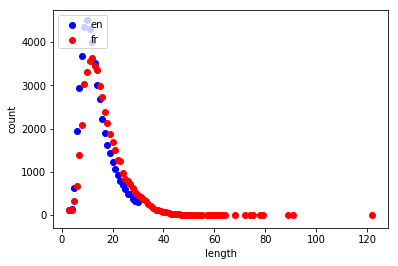

In [39]:
plot_seq_lngths(en_ids, fr_ids)

In [40]:
enlen_99 = int(np.percentile([len(o) for o in en_ids], 99))
enlen_99

29

In [41]:
frlen_98 = int(np.percentile([len(o) for o in fr_ids], 98))
frlen_98

35

In [42]:
en_ids_tr = np.array([o[:enlen_99] for o in en_ids])
fr_ids_tr = np.array([o[:frlen_98] for o in fr_ids])

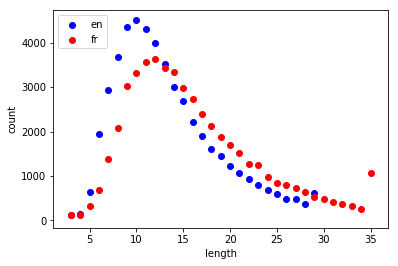

In [43]:
#after truncation
plot_seq_lngths(en_ids_tr, fr_ids_tr)

In [44]:
#pytorch Dataset requires 2 things - a length and a indexer
class GeneralDataset(Dataset):
    def __init__(self, x, y): 
        self.x,self.y = x,y
        
    def __getitem__(self, idx): 
        #return a numpy array of tuples
        return A(self.x[idx], self.y[idx])
    
    def __len__(self): 
        return len(self.x)

In [45]:
#create training and validation set. index into bool arrays
np.random.seed(42)
trn_keep = np.random.rand(len(en_ids_tr))>0.1
en_trn,fr_trn = en_ids_tr[trn_keep],fr_ids_tr[trn_keep]
en_val,fr_val = en_ids_tr[~trn_keep],fr_ids_tr[~trn_keep]
len(en_trn),len(en_val)

(45219, 5041)

In [46]:
#switch these two around tp translate en->fr
trn_ds = GeneralDataset(fr_trn,en_trn)
val_ds = GeneralDataset(fr_val,en_val)

In [47]:
bs=370

In [48]:
#make more time & memory efficient, sortish sampled on length
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [49]:
trn_ds.x[0]

[42, 13, 38, 15, 8, 2465, 4, 2]

In [50]:
#we transpose both x and y, presumably due to matrix mult on the batch
#pad_idx - pads shorter sentences tso that tensor equal length
#pre_pad - for decoder want padding to be at the end (for classifier want padding at start - 
#as want last token to rep. final word in the movie review)
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, pad_idx=1, pre_pad=False, sampler=val_samp)
#md just really does one thing, store val set, test set and patch in a single object
md = ModelData(PATH, trn_dl, val_dl)

In [51]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(35, 29), (31, 9), (35, 8), (35, 14), (25, 9)]

## Initial model

Start with the Encoder

In [52]:
def create_emb(vecs, itos, em_sz):
    #vecs: pretrained vectors
    #itos: note for Embedding rows must equal vocab size
    #em_sz: determined by fastText (300) 
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    #learnable objects have a weight attrib which has a data attrib (type tensor)
    wgts = emb.weight.data
    len_wgts = len(wgts)
    miss = []
    #so can start out using fastText embeddings we replace the random embedddings above with pretrained ones
    for i,w in enumerate(itos):
        try: 
            #our pre-trained weights have a std dev of ~0.3, random wghts have std dev of ~1
            wgts[i] = torch.from_numpy(vecs[w]*3)
        except: 
            #keep track of ones we dont find
            miss.append(w)
    print(f'len(wgts): {len_wgts}, len(missed): {len(miss)}, miss[5:10]: {miss[5:10]}, % missed: {(len(miss)/len_wgts)*100}')
    return emb

In [53]:
#whay are we using 256 for number of hidden?
nh,nl = 256,2

![title](img/merity_google_nmt_arch.png)

In [54]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.rnn_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        #self.rnn_enc = nn.LSTM(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        #Linear to convert number of hidden to embedding size
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.rnn_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        #self.rnn_dec = nn.LSTM(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        #initialize hidden state
        h = self.initHidden(bs)
        #create embeddings then do dropout
        emb = self.emb_enc_drop(self.emb_enc(inp))
        #rnn spits out 2 things: list of state at every time step (enc_out ) and  state at last time step (h)
        enc_out, h = self.rnn_enc(emb, h)
        #want final hidden state to contain vector cotaining what sentence said and how it says it
        #we use state at last time step for input into our decoder (gru_dec in for loop)
        h = self.out_enc(h)

        #start our decoder sequence with bos token ie 0
        dec_inp = V(torch.zeros(bs).long())
        res = []
        #where out_sl is the length of the largest sentence (here english)
        for i in range(self.out_sl):
            #-find the vector for this token - create embeddings, note we add a leading unit axis to the start
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.rnn_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            #pdb.set_trace()
            #outp is tensor[bs x number of words in en vocab]
            #each row is a probability for each word that it is that word
            res.append(outp)
            #find word with highest prob, get the secod item ie the index
            dec_inp = V(outp.data.max(1)[1])
            #if padding (1) then finished
            if (dec_inp==1).all(): 
                break
        #stack up probability outputs to a tensor
        return torch.stack(res)
    
    def initHidden(self, bs): 
        #Returns a tensor filled with the scalar value `0`, with the shape defined
        #by the varargs :attr:`sizes`.
        zero_tensor = V(torch.zeros(self.nl, bs, self.nh))
        #torch.autograd.variable.Variable
        #print(type(zero_tensor.shape[0]))
        return zero_tensor

In [106]:
#cross entropy loss. Sequence len of venerated may be different to target (may have stopped early), so need to add some padding
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    #our rank 3 tensor input [seq_len x bs x vocab_len] requires a 6 tuple
    if sl>sl_in: 
        input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    #cross entropy loss expects a rank 2 tensor so we do view(-1) to flatten
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

In [107]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [108]:
#Seq2SeqRNN(vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2)
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_99)
#treat and single learning rate group. pytorch model->fastai model->fastai learner
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

len(wgts): 24793, len(missed): 2547, miss[5:10]: ['t_up', 'd’', 'qu’', 's’', 'n’'], % missed: 10.273060944621466
len(wgts): 17573, len(missed): 1288, miss[5:10]: ["'s", '’s', "n't", 'n’t', ':'], % missed: 7.329425823706822


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 67%|██████▋   | 83/123 [00:13<00:06,  6.12it/s, loss=40.8]

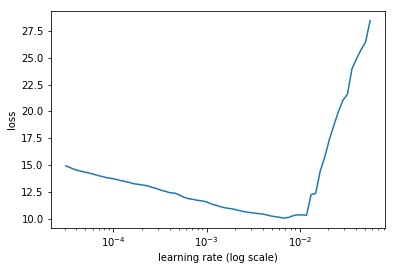

In [109]:
learn.lr_find()
learn.sched.plot()

In [110]:
lr=3e-3

In [111]:
vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=1, cycle_len=12, use_clr=(20,10), get_ep_vals=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

 32%|███▏      | 39/123 [00:06<00:13,  6.22it/s, loss=9.08]

Exception in thread Thread-66:
Traceback (most recent call last):
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   
    0      7.155763   5.964261  
    1      5.418141   5.901381  
    2      5.285075   5.099594  
    3      4.926439   5.047533  
    4      4.479924   4.353765  
    5      4.553568   4.200086  
    6      4.318037   4.605956  
    7      3.939093   3.795301  
    8      3.646367   3.730725  
    9      3.457662   3.773596  
    10     3.404771   3.64608   
    11     3.360436   3.6025    



In [112]:
vals_s2s

[array([3.6025])]

In [113]:
def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = ep_vals.keys()
    plt.xticks(np.asarray(list(epochs)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    val_losses = [item[1] for item in list(ep_vals.values())]
    plt.plot(epochs, trn_losses, c='b', label='train')
    plt.plot(epochs, val_losses, c='r', label='validation')
    plt.legend(loc='upper left')

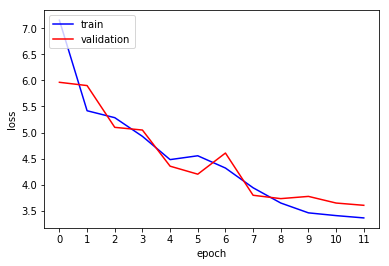

In [114]:
plot_ep_vals(ep_vals_s2s)

In [64]:
learn.save('initial')

In [65]:
learn.load('initial')

## Test

In [66]:
x, y = next(iter(val_dl))
probs = learn.model(V(x))
probs_arr = learn.predict_array(x)
preds = to_np(probs.max(2)[1])

In [67]:
preds[:,1]

array([6, 9, 5, 5, 5, 5, 5, 4, 2, 2, 4, 4, 4, 4, 2, 2, 2, 4, 4, 2, 5, 4, 2, 2, 1, 1, 1, 4, 2])

In [68]:
probs_arr[:,1], probs[:,1]

(array([[-2.81174,  2.6552 ,  2.1653 , ...,  2.66928,  2.94825,  5.65754],
        [-3.41418,  3.3842 ,  0.82691, ...,  1.33455,  0.88323,  4.59705],
        [-2.6858 ,  3.57617,  1.15598, ...,  0.94627, -0.05184,  3.50251],
        ...,
        [-1.67884,  5.78447,  5.5766 , ..., -6.67778, -7.59777, -6.8463 ],
        [-1.66133,  5.72123,  5.62545, ..., -6.6751 , -7.56132, -6.94502],
        [-1.58249,  5.7038 ,  5.76588, ..., -6.72052, -7.62736, -7.05345]], dtype=float32),
 Variable containing:
 -2.8117e+00  2.6552e+00  2.1653e+00  ...   2.6693e+00  2.9482e+00  5.6575e+00
 -3.4142e+00  3.3842e+00  8.2691e-01  ...   1.3346e+00  8.8323e-01  4.5971e+00
 -2.6858e+00  3.5762e+00  1.1560e+00  ...   9.4627e-01 -5.1840e-02  3.5025e+00
                 ...                   ⋱                   ...                
 -1.6788e+00  5.7845e+00  5.5766e+00  ...  -6.6778e+00 -7.5978e+00 -6.8463e+00
 -1.6613e+00  5.7212e+00  5.6255e+00  ...  -6.6751e+00 -7.5613e+00 -6.9450e+00
 -1.5825e+00  5.7038e+00

In [69]:
for i in range(170,173):
    print('x: '+' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print('y: '+ ' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print('pred: '+' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

x: que considérez - vous comme les lacunes / besoins clés transversaux et dans des domaines précis de la recherche en hygiène de l’ environnement au canada ? _eos_
y: what do you consider to be the key issue - specific and cross - cutting gaps / needs in environmental health research in canada ? _eos_
pred: what is the the the the ? _eos_ _eos_ ? ? _eos_ ? ? _eos_ _eos_ ? ? _eos_ _eos_ ?

x: que faire si le crédit pour la t_up tps / t_up tvh de l’ époux ou conjoint de fait survivant comprend un montant pour la personne décédée ? _eos_
y: what if the surviving spouse ’s or common - law partner ’s t_up gst / t_up hst credit includes a claim for the deceased ? _eos_
pred: what is the the the the ? _eos_ _eos_ ? ? ? _eos_ _eos_ ? ? _eos_ the ? _eos_ _eos_ ? _eos_

x: quelle est la validité d' un paiement qui est soit dérisoire , soit sans rapport avec le coût de production du médicament offert comme échantillon ? _eos_
y: what is the validity of a payment which is either insignificant or n

1:12
Even sequence to sequence models with limited data can be suprisingly effective

## Bdir

For classification, we took all the tokens, turned them around then trained a new classifier

People tend not to do bidirectional on Decoder but may work

In [70]:
class Seq2SeqRNN_Bidir(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        #note we specify bidirectional=True
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.05)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        #only real difference to Seq2SeqRNN above
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    #note now initHidden retuns nl*2
    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))
        

In [115]:
rnn = Seq2SeqRNN_Bidir(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_99)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

len(wgts): 24793, len(missed): 2547, miss[5:10]: ['t_up', 'd’', 'qu’', 's’', 'n’'], % missed: 10.273060944621466
len(wgts): 17573, len(missed): 1288, miss[5:10]: ["'s", '’s', "n't", 'n’t', ':'], % missed: 7.329425823706822


In [116]:
vals_bdir, ep_vals_bdir = learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), get_ep_vals=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

epoch      trn_loss   val_loss   
    0      6.652701   5.917885  
    1      5.030208   4.924429  
    2      4.598036   4.197263  
    3      4.046396   3.864782  
    4      3.786      3.714006  
    5      3.594805   3.564516  
    6      3.485211   3.510993  
    7      3.271157   3.474967  
    8      3.106892   3.449804  
    9      2.968612   3.415976  
    10     3.006177   3.397062  
    11     2.810424   3.397787  



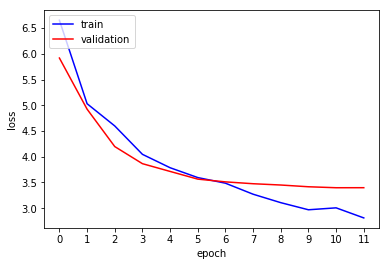

In [117]:
plot_ep_vals(ep_vals_bdir)

In [74]:
learn.save('bidir')

## Teacher forcing

When model starts learning, it doesnt know anything. Early learning will be very difficult.

So instead of feeding in the thing predicted just now, feed in the actual correct word it was meant to be.

Cant do at inference time, so we have a pr_force variable. At start of training we set this very high

In [75]:
#override step method of Stepper
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        #this line is the only change to step. Linear decrease to 0 after 10 epochs
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
        output = self.m(*xs, y)
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data[0]

In [76]:
class Seq2SeqRNN_TeacherForcing(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 1.
        
    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): 
                break
            #note pr_force, is set high when we start, decrease to zero near end
            if (y is not None) and (random.random()<self.pr_force):
                #if already longer than the target sentence then stop
                if i>=len(y): 
                    break
                dec_inp = y[i]
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [118]:
rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_99)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

len(wgts): 24793, len(missed): 2547, miss[5:10]: ['t_up', 'd’', 'qu’', 's’', 'n’'], % missed: 10.273060944621466
len(wgts): 17573, len(missed): 1288, miss[5:10]: ["'s", '’s', "n't", 'n’t', ':'], % missed: 7.329425823706822


In [119]:
vals_force, ep_vals_force = learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), stepper=Seq2SeqStepper, get_ep_vals=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

epoch      trn_loss   val_loss   
    0      5.320341   7.440421  
    1      4.254137   10.60189  
    2      4.351503   6.816565  
    3      3.94851    5.862771  
    4      3.628818   4.800807  
    5      3.589554   4.090904  
    6      3.35808    3.968926  
    7      3.278247   4.861075  
    8      3.357374   3.775269  
    9      3.375207   3.509184  
    10     3.135683   3.453672  
    11     3.096447   3.450966  



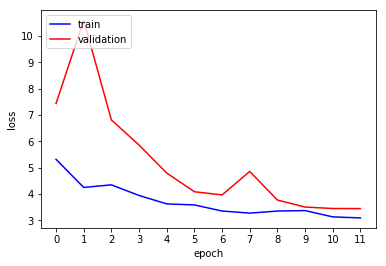

In [120]:
plot_ep_vals(ep_vals_force)

In [80]:
learn.save('forcing')

## Attention Model

1:32 Use intermediate state steps rather than just final. Train NN to figure out what is important

see https://distill.pub/2016/augmented-rnns/

![title](img/olah_carter_2016.png)

In [86]:
def rand_t(*sz):
    print(f'sz[0]: {sz[0]}')
    return torch.randn(sz)/math.sqrt(sz[0])

def rand_p(*sz):
    #Paramater is identitical to Variable but tells pytorch to learn the weights
    return nn.Parameter(rand_t(*sz))

In [96]:
class Seq2SeqAttnRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec*2, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        #random weight watrix
        self.W1 = rand_p(nh, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec)
        self.V = rand_p(em_sz_dec)
        
    def forward(self, inp, y=None, ret_attn=False):
        sl, bs=inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        
        dec_inp = V(torch.zeros(bs).long())
        res, attns = [],[]
        #numpy.matrixmul ie dot product
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            #create a little neural net and use softmax
            #take last layers hidden state h[-1] (ie current state of decoder) & put in a Linear layer
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            #linear layer, matmult, non lin activation = neural net with one hidden
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            #use this nn to encode our outputs
            #multiply all the weigths (enc_out) by the output of our little neural net (a)
            #hopefully will learn to mult enc_output weights by something useful
            Xa = (a.unsqueeze(2)*enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all():
                break
            if (y is not None) and (random.random()<self.pr_force):
                if i >= len(y): 
                    break
                dec_inp = y[i]
                
        res = torch.stack(res)
        if ret_attn:
            #add on the a value so we can plot it
            res = res, torch.stack(attns)
        return res
              
    def initHidden(self, bs):
        return V(torch.zeros(self.nl, bs, self.nh))
        

In [121]:
rnn = Seq2SeqAttnRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_99)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

len(wgts): 24793, len(missed): 2547, miss[5:10]: ['t_up', 'd’', 'qu’', 's’', 'n’'], % missed: 10.273060944621466
len(wgts): 17573, len(missed): 1288, miss[5:10]: ["'s", '’s', "n't", 'n’t', ':'], % missed: 7.329425823706822
sz[0]: 256
sz[0]: 300


In [122]:
lr = 2e-3

In [123]:
vals_attn, ep_vals_attn = learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper= Seq2SeqStepper, get_ep_vals=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   
    0      5.896815   7.289288  
    1      7.603035   11.643151 
    2      4.534801   10.11118  
    3      4.386712   5.675688  
    4      4.215388   5.690677  
    5      4.270782   4.523891  
    6      3.761999   4.438368  
    7      3.984526   4.025942  
    8      3.613276   3.785742  
    9      3.796744   3.776984  
    10     3.6051     3.617373  
    11     3.47593    3.540958  
    12     3.309098   3.498903  
    13     3.381942   3.46814   
    14     3.192933   3.453446  



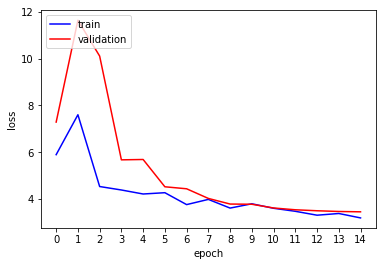

In [124]:
plot_ep_vals(ep_vals_attn)

In [101]:
learn.save('attn')

In [102]:
learn.load('attn')

In [132]:
from matplotlib.pyplot import cm 
def plot_all_ep_vals(ep_val_dict):
    plt.ylabel("val_loss")
    plt.xlabel("epoch")
    color=iter(cm.rainbow(np.linspace(0,1,len(ep_val_dict))))
    for k, v in ep_val_dict.items():
        epochs = ep_val_dict[k].keys()
        plt.xticks(np.asarray(list(epochs)))
        val_losses = [item[1] for item in list(ep_val_dict[k].values())]
        c=next(color)
        plt.plot(epochs, val_losses, c=c, label=k)
    plt.legend(loc='upper left')

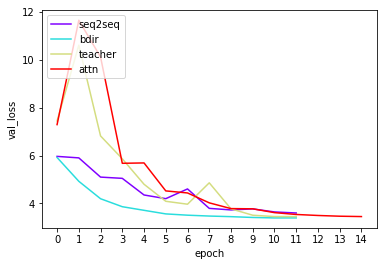

In [133]:
ep_val_dict = {}
ep_val_dict['seq2seq'] = ep_vals_s2s
ep_val_dict['bdir'] = ep_vals_bdir
ep_val_dict['teacher'] = ep_vals_force
ep_val_dict['attn'] = ep_vals_attn
plot_all_ep_vals(ep_val_dict)

## Test

In [134]:
x,y = next(iter(val_dl))
probs,attns = learn.model(V(x),ret_attn=True)
preds = to_np(probs.max(2)[1])

In [135]:
for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

quelles composantes des différents aspects de la performance devraient être mesurées , quelles données pertinentes recueillir et comment ? _eos_
which components within various performance areas should be measured , whatkinds of data are appropriate to collect , and how should this be done ? _eos_
what types of characteristics should be be and and and how how ? ? ?

le premier ministre doit - il nommer un ministre d’ état à la santé mentale , à la maladie mentale et à la toxicomanie ? _eos_
what role can the federal government play to ensure that individuals with mental illness and addiction have access to the drug therapy they need ? _eos_
what is the minister minister minister minister minister minister minister minister to health health , health ? ? ?

quelles sont les conséquences de la hausse des formes d’ emploi non conformes aux normes chez les travailleurs hautement qualifiés et chez ceux qui occupent des emplois plus marginaux ? _eos_
what is the impact of growing forms of non

In [136]:
attn = to_np(attns[...,180])

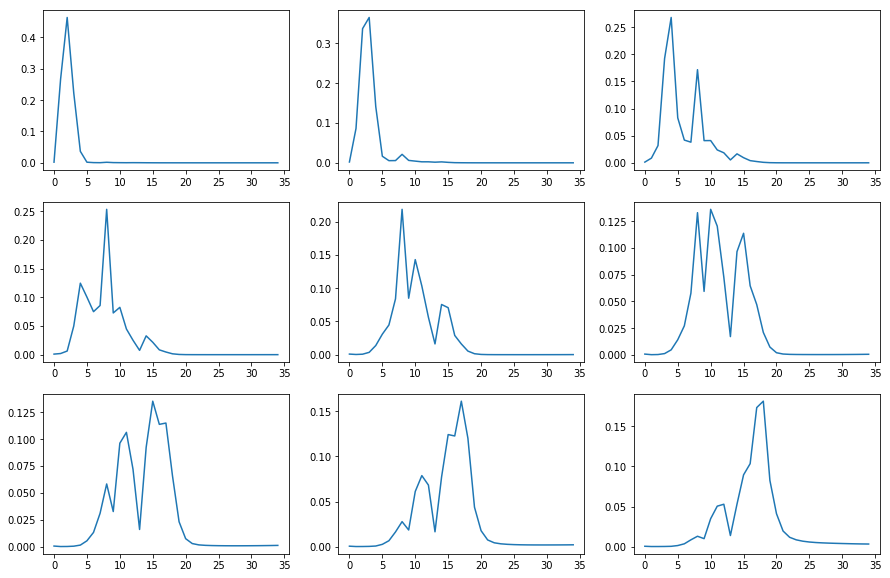

In [137]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(attn[i])

## All

In [139]:
class Seq2SeqRNN_All(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.25)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh*2, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh*2, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)

    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [141]:
rnn = Seq2SeqRNN_All(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_99)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

len(wgts): 24793, len(missed): 2547, miss[5:10]: ['t_up', 'd’', 'qu’', 's’', 'n’'], % missed: 10.273060944621466
len(wgts): 17573, len(missed): 1288, miss[5:10]: ["'s", '’s', "n't", 'n’t', ':'], % missed: 7.329425823706822
sz[0]: 512
sz[0]: 300


In [142]:
vals, ep_vals_all = learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper, get_ep_vals = True)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

  0%|          | 0/123 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58